### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

#### Import libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# read the data
df = pd.read_csv(r'finalNew.csv')

In [33]:
df.shape

(4095, 41)

In [34]:
df.drop_duplicates(keep = 'first',inplace = True)

In [35]:
df.shape
df = df.drop(columns=['Unnamed: 0'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4095 entries, 0 to 4094
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Consultant Mail ID           4095 non-null   object 
 1   Resource Primary Skill       2594 non-null   object 
 2   utilization                  2594 non-null   float64
 3   Hire Date                    2594 non-null   object 
 4   Pillar                       2594 non-null   object 
 5   Domain 1                     2594 non-null   object 
 6   Level                        2594 non-null   object 
 7   Capacity Hours               2594 non-null   float64
 8   Billable Hours               2594 non-null   float64
 9   Separation Date              2594 non-null   object 
 10  Exit                         2594 non-null   object 
 11  diff_in_days                 2594 non-null   object 
 12  diff_in_years                2594 non-null   float64
 13  rehire            

In [37]:
df.drop(columns = ['Billable Hours','Capacity Hours'], inplace = True)

In [38]:
df.columns

Index(['Consultant Mail ID', 'Resource Primary Skill', 'utilization',
       'Hire Date', 'Pillar', 'Domain 1', 'Level', 'Separation Date', 'Exit',
       'diff_in_days', 'diff_in_years', 'rehire', 'Promoted', 'Location',
       'Max Count of Unique Project', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       'onsite_info', 'Region', 'Sub Region', 'Investment', 'Training'],
      dtype='object')

In [39]:
categorical_columns = ['Resource Primary Skill', 'Domain 1', 'Pillar', 'Level','Location','Region','Sub Region']  # List your categorical columns here

# # Applying frequency encoding to each categorical column
# for col in categorical_columns:
#     # Calculate the frequency of each category
#     freq_encoding = df[col].value_counts(normalize=True)  # Use normalize=True to get the proportion instead of counts if preferred
    
#     # Map the frequencies to the original column
#     df[col] = df[col].map(freq_encoding)

In [40]:
# Applying OHE, pd.get_dummies automatically excludes numerical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)

In [41]:
df_encoded.isnull().sum()

Consultant Mail ID                                                                   0
utilization                                                                       1501
Hire Date                                                                         1501
Separation Date                                                                   1501
Exit                                                                              1501
diff_in_days                                                                      1501
diff_in_years                                                                     1501
rehire                                                                            1501
Promoted                                                                          1501
Max Count of Unique Project                                                       1595
1                                                                                 1595
2                                          

In [42]:
df_encoded.columns

Index(['Consultant Mail ID', 'utilization', 'Hire Date', 'Separation Date',
       'Exit', 'diff_in_days', 'diff_in_years', 'rehire', 'Promoted',
       'Max Count of Unique Project',
       ...
       'Sub Region_NACT', 'Sub Region_Netsuite Consulting', 'Sub Region_Non C',
       'Sub Region_North Consulting Applications',
       'Sub Region_North East Consulting Tech',
       'Sub Region_South Consulting Applications',
       'Sub Region_South Consulting Technology',
       'Sub Region_UK-IE Consulting Apps', 'Sub Region_US Consulting',
       'Sub Region_WE Consulting Tech'],
      dtype='object', length=190)

In [43]:
df_encoded.dropna(inplace = True)

### Exploration around the left candidates

In [44]:
left_candidates = df[df['Exit']==1]

In [45]:
left_candidates.shape

(722, 38)

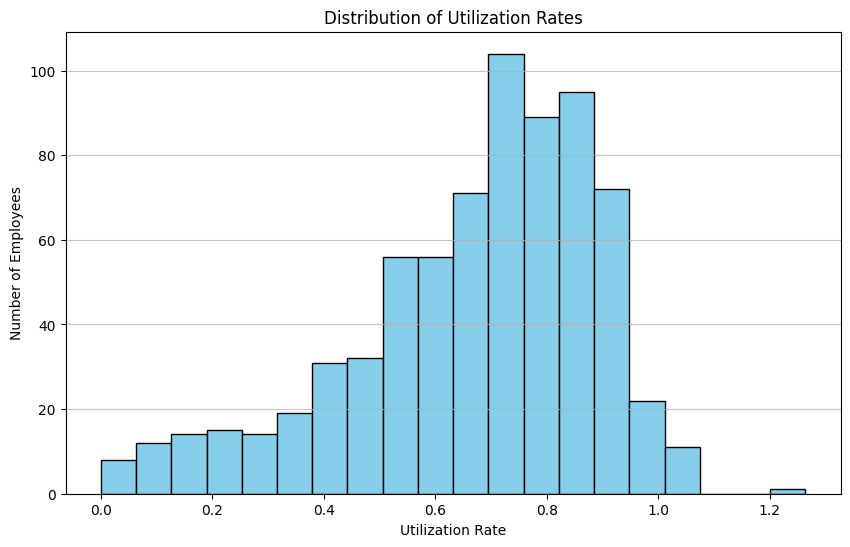

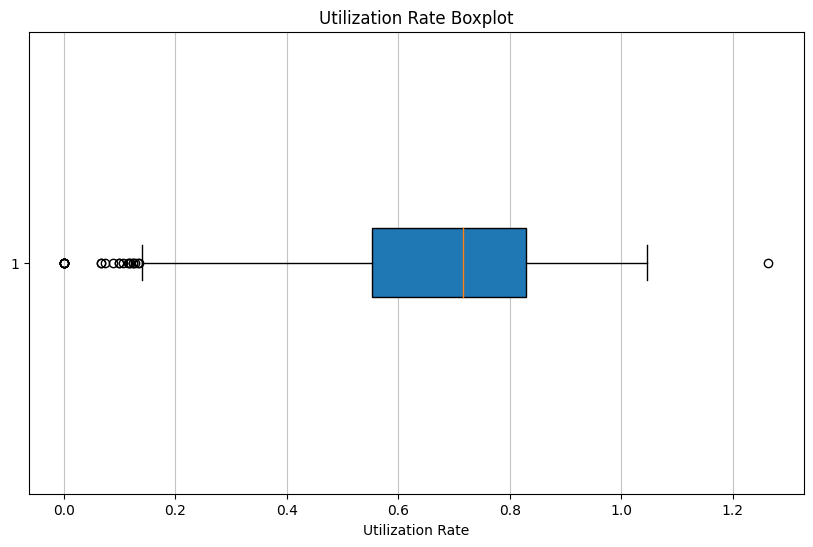

In [46]:
# Histogram of utilization rates
plt.figure(figsize=(10, 6))
plt.hist(left_candidates['utilization'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Utilization Rates')
plt.xlabel('Utilization Rate')
plt.ylabel('Number of Employees')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Boxplot to visualize outliers and distribution
plt.figure(figsize=(10, 6))
plt.boxplot(left_candidates['utilization'], vert=False, patch_artist=True)
plt.title('Utilization Rate Boxplot')
plt.xlabel('Utilization Rate')
plt.grid(axis='x', alpha=0.75)
plt.show()

- Utilization rates of those who have left shows that at least 60-70% of the candidates were utilized close to 80% and there are a very few cases like close 10% of them over utilized, above 100%
- While on the contradicting side there are cases where candidates had lower/almost zero utilization rates which can also be a reason why these candidates might have left and the box plot clearly shows that the outliers ~10% of them were utilized below 20%

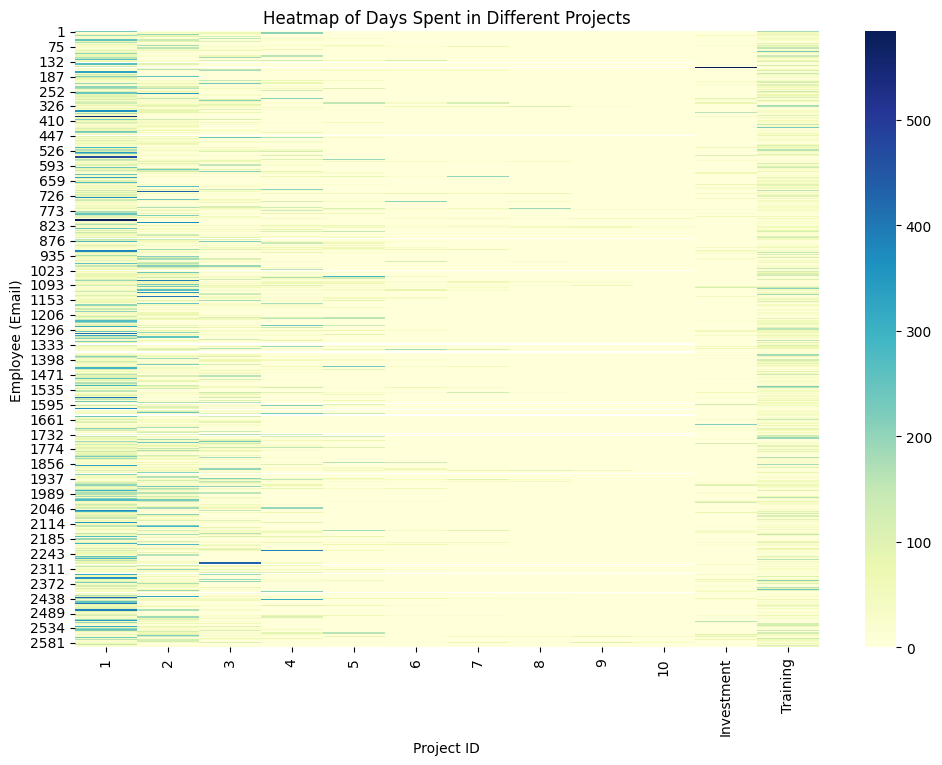

In [47]:
# Heatmap of days spent on projects
time_spent_in_projects = left_candidates[['Consultant Mail ID','1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10','Investment','Training']].drop_duplicates(keep = 'first')
plt.figure(figsize=(12, 8))
sns.heatmap(time_spent_in_projects.drop('Consultant Mail ID', axis=1), cmap="YlGnBu")
plt.title('Heatmap of Days Spent in Different Projects')
plt.xlabel('Project ID')
plt.ylabel('Employee (Email)')
plt.show()

The heat map is a clear indicator that in most of the cases the lack of diversity in projects acted as a key component for an employee to decide to leave the organization

/tmp/ipykernel_19981/1427486006.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_sorted['Consultant Mail ID'], rotation=45, ha='right')


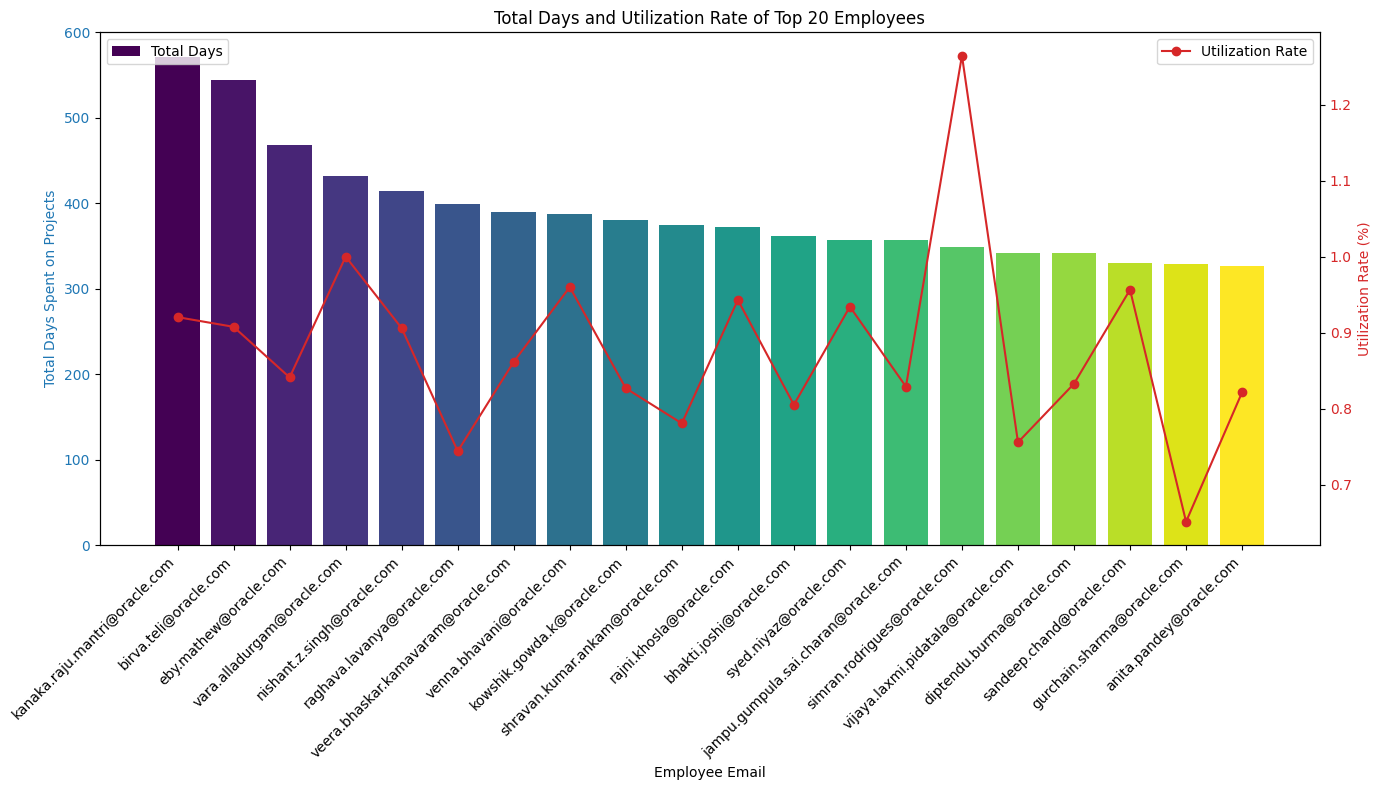

In [48]:
project1 = left_candidates[['Consultant Mail ID','1', 'utilization']].drop_duplicates(keep = 'first')
# Drop the 'Email' column for aggregation, then sum the days across all projects for each employee
# project1['TotalDays'] = project1.drop('Consultant Mail ID', axis=1).sum(axis=1)
# Sort the DataFrame based on 'TotalDays' to get the top 20 employees with the most days spent on projects
df_sorted = project1.sort_values(by='1', ascending=False).head(20)
# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for Total Days Spent on Projects
colors = plt.cm.viridis(np.linspace(0, 1, len(df_sorted)))
ax1.bar(df_sorted['Consultant Mail ID'], df_sorted['1'], color=colors, label='Total Days')
ax1.set_xlabel('Employee Email')
ax1.set_ylabel('Total Days Spent on Projects', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticklabels(df_sorted['Consultant Mail ID'], rotation=45, ha='right')

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_sorted['Consultant Mail ID'], df_sorted['utilization'], color='tab:red', label='Utilization Rate', marker='o', linestyle='-')
ax2.set_ylabel('Utilization Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
plt.title('Total Days and Utilization Rate of Top 20 Employees')
fig.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

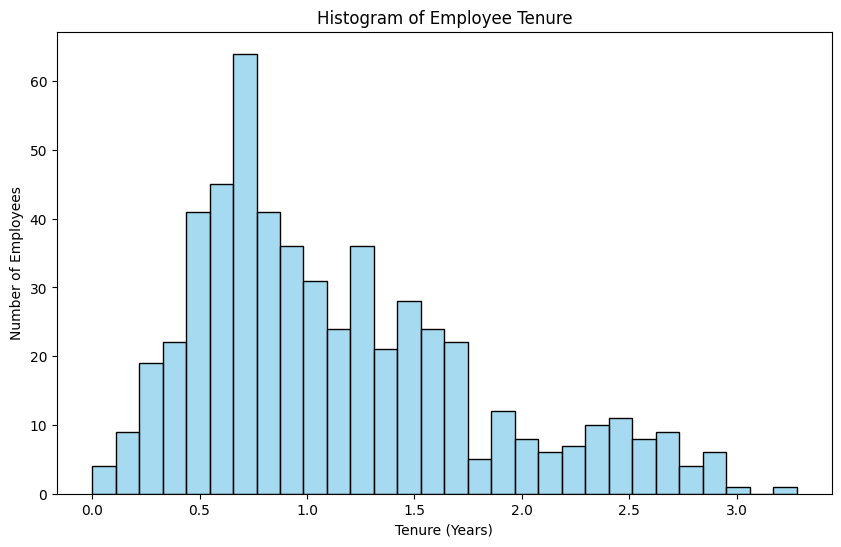

/tmp/ipykernel_19981/2976886331.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tenure['diff_in_years'], shade=True, color='orange')


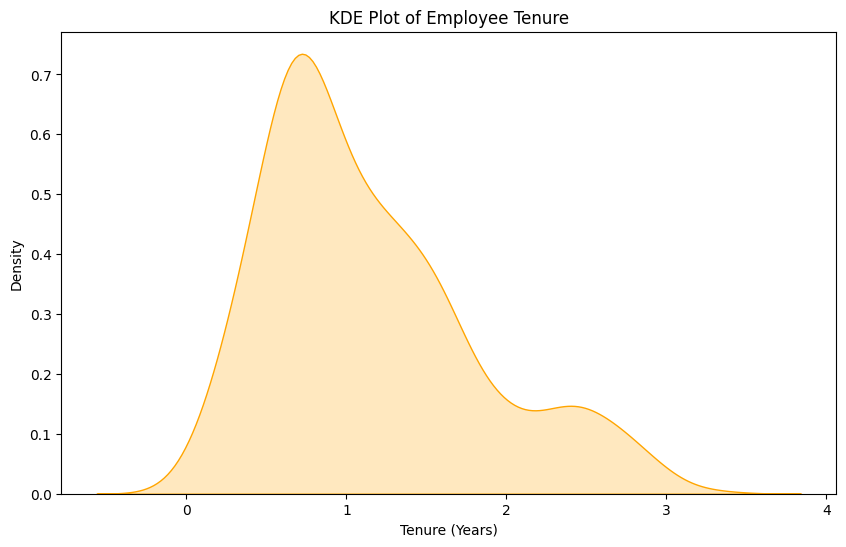

In [49]:
# Tenure of service visualization
tenure = left_candidates[left_candidates['diff_in_years']<=4].drop_duplicates(keep = 'first')
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(tenure['diff_in_years'], bins=30, kde=False, color='skyblue')
plt.title('Histogram of Employee Tenure')
plt.xlabel('Tenure (Years)')
plt.ylabel('Number of Employees')
plt.show()

# KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(tenure['diff_in_years'], shade=True, color='orange')
plt.title('KDE Plot of Employee Tenure')
plt.xlabel('Tenure (Years)')
plt.ylabel('Density')
plt.show()

In [50]:
# correlation analysis between numerical variables
left_candidates = left_candidates.drop_duplicates(keep = 'first')

In [51]:
df.columns

Index(['Consultant Mail ID', 'Resource Primary Skill', 'utilization',
       'Hire Date', 'Pillar', 'Domain 1', 'Level', 'Separation Date', 'Exit',
       'diff_in_days', 'diff_in_years', 'rehire', 'Promoted', 'Location',
       'Max Count of Unique Project', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       'onsite_info', 'Region', 'Sub Region', 'Investment', 'Training'],
      dtype='object')

In [52]:
from scipy.stats import chi2_contingency
# Step 1: Create a contingency table
contingency_table = pd.crosstab(left_candidates['Promoted'], left_candidates['Exit'])

print("Contingency Table:")
print(contingency_table)

# Step 2: Conduct the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)

Contingency Table:
Exit      True
Promoted      
False      539
True        17

Chi-square Statistic: 0.0
P-value: 1.0


There is no signifcant relationship between promotion status and the employees who have left the company, however let's try to conduct the same test on the complete dataset where we have those employees who still exist in the company

In [53]:
from scipy.stats import chi2_contingency
# Step 1: Create a contingency table
contingency_table = pd.crosstab(df['Promoted'], df['Exit'])

print("Contingency Table:")
print(contingency_table)

# Step 2: Conduct the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)

Contingency Table:
Exit      False  True 
Promoted              
False      1863    689
True          9     33

Chi-square Statistic: 52.17696582381493
P-value: 5.07175781582042e-13


In [54]:
# Step 1: Create a contingency table
contingency_table = pd.crosstab(df['Resource Primary Skill'], df['Exit'])

print("Contingency Table:")
print(contingency_table)

# Step 2: Conduct the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)

Contingency Table:
Exit                                                False  True 
Resource Primary Skill                                          
ERP Cloud/EBS Data Migration Extract                    1      0
ERP Cloud/FIN Accounting Hub                            7      0
ERP Cloud/FIN Financials                               33      3
ERP Cloud/FIN PPM/Projects                              0      1
ERP Cloud/PSFT Data Migration Extract                   3      0
ERP Cloud/PaaS Extension - DB/ORDS                      1      0
ERP Cloud/PaaS Extension â€“ OIC                        3      0
ERP Cloud/PaaS Integrations                            15      1
ERP Cloud/Project Manager                               3      0
ERP Cloud/Reporting & Analytics                        40      0
ERP Cloud/S&C Advanced Financial Controls               1      0
ERP Cloud/SCM Build Inventory                           2      0
ERP Cloud/SCM Costing                                   8      0
ERP Cl

In [55]:
# Step 1: Create a contingency table
contingency_table = pd.crosstab(df['Region'], df['Exit'])

print("Contingency Table:")
print(contingency_table)

# Step 2: Conduct the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)

Contingency Table:
Exit                  False  True 
Region                            
APAC                    238    149
APAC Consulting         110      7
EMEA Consulting Apps    785    388
EMEA Consulting Tech    144     45
JAPAN                    17      8
LAD Apps                 25     13
LAD Tech                  2      0
NAAC                    302     22
NACT                     28     10
XLOB                    172     80

Chi-square Statistic: 140.46400076821192
P-value: 8.274240075649668e-26


In [56]:
pd.set_option('display.max_rows', 500)
df_encoded.isnull().sum().T

Consultant Mail ID                                                                0
utilization                                                                       0
Hire Date                                                                         0
Separation Date                                                                   0
Exit                                                                              0
diff_in_days                                                                      0
diff_in_years                                                                     0
rehire                                                                            0
Promoted                                                                          0
Max Count of Unique Project                                                       0
1                                                                                 0
2                                                                           

In [57]:

y = y.astype(int)

Hence from the chi-square tests it is clear that the promotion status, location and resource primary skills play a vital role for an employee to decide whether to stay or leave the organization

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['Exit','Separation Date', 'Hire Date','diff_in_days','Consultant Mail ID'], axis=1)  # Features
y = df_encoded['Exit']  # Target variable
y = y.astype(int)
# print(y)

# # Splitting data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing and fitting the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Getting feature importances
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sorting features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                               Feature    Importance
1                                        diff_in_years  1.938805e-01
2                                               rehire  1.328409e-01
134                                            Level_C  9.121416e-02
5                                                    1  4.857342e-02
0                                          utilization  4.639282e-02
25                                            Training  4.289010e-02
6                                                    2  3.639533e-02
7                                                    3  2.786718e-02
4                          Max Count of Unique Project  2.441088e-02
8                                                    4  1.918418e-02
24                                          Investment  1.602687e-02
9                                                    5  1.300474e-02
128                                            Level_5  1.188756e-02
69   Resource Primary Skill_Global

In [59]:
importance_df.head(10)

,Feature,Importance
1,diff_in_years,0.193880
2,rehire,0.132841
134,Level_C,0.091214
5,1,0.048573
0,utilization,0.046393
25,Training,0.042890
6,2,0.036395
7,3,0.027867
4,Max Count of Unique Project,0.024411
8,4,0.019184


In [60]:
len(features)

185

In [61]:
# Convert feature importances to a Series for easier filtering
feature_importances = pd.Series(importances, index=X.columns)

# Filter features by importance
important_features = feature_importances[feature_importances > 0.0].index.tolist()

# Filter df_encoded to keep only important features (and target variable)
df_filtered = df_encoded[important_features + ['Exit']]

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

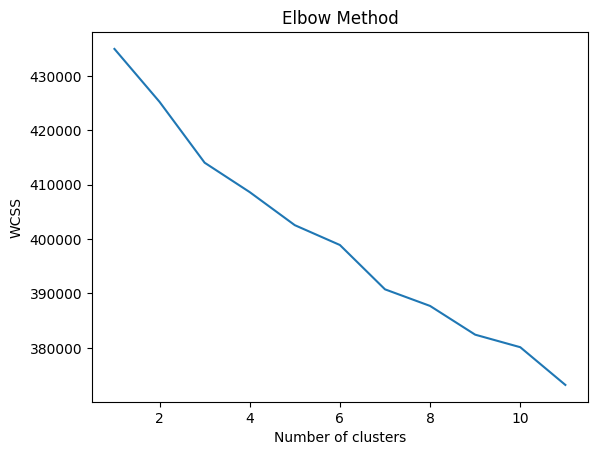

In [63]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 12):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [64]:
# Replace 'k' with your chosen number of clusters
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=19)
clusters = kmeans.fit_predict(df_scaled)

# Add the cluster labels to your original DataFrame (for analysis)
df_filtered['Cluster'] = clusters

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_19981/3159347507.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cluster'] = clusters


In [65]:
# Assuming 'left_company' is in your original DataFrame to indicate if an employee left
# cluster_analysis = X_train_filtered.copy()
# cluster_analysis['left_company'] = y_train  # y_train contains your target variable

# # Calculate averages for each cluster
# cluster_averages = cluster_analysis.groupby('Cluster').mean()

# cluster_averages.T

In [66]:
cluster_means = df_filtered.groupby('Cluster').mean()

In [67]:
cluster_means

,utilization,diff_in_years,rehire,Promoted,Max Count of Unique Project,1,2,3,4,5,...,Sub Region_Netsuite Consulting,Sub Region_Non C,Sub Region_North Consulting Applications,Sub Region_North East Consulting Tech,Sub Region_South Consulting Applications,Sub Region_South Consulting Technology,Sub Region_UK-IE Consulting Apps,Sub Region_US Consulting,Sub Region_WE Consulting Tech,Exit
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.637326,1.593413,0.12766,0.0,2.744681,91.692819,60.671543,20.127394,19.617553,8.119681,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.234043
1,0.690504,1.617179,0.047297,0.0,2.682432,108.808509,55.960938,32.857264,15.409333,4.512880,...,0.000000,0.000000,0.067568,0.000000,0.0,0.000000,0.172297,0.000000,0.000000,0.246622
2,0.753747,1.975262,0.102941,0.014706,4.779412,70.883088,79.327353,45.397426,27.261765,17.366728,...,0.000000,0.000000,0.000000,0.000000,0.0,0.058824,0.000000,0.000000,0.529412,0.176471
3,0.735546,1.727276,0.091176,0.002941,2.835294,137.683971,67.636213,36.173713,16.375368,9.370588,...,0.000000,0.008824,0.173529,0.000000,0.0,0.000000,0.073529,0.000000,0.000000,0.261765
4,0.710214,1.570316,0.067797,0.004237,2.540254,116.754939,59.042624,27.807865,14.880297,6.764698,...,0.000000,0.036017,0.044492,0.019068,0.0,0.055085,0.021186,0.002119,0.040254,0.252119
5,0.666159,1.671170,0.059633,0.0,3.000000,100.874490,58.070155,33.988102,15.378698,12.674169,...,0.000000,0.073394,0.082569,0.000000,0.0,0.000000,0.045872,0.004587,0.000000,0.229358
6,0.720118,1.796655,0.0,0.0,2.251701,124.015051,60.476488,20.871003,5.260629,1.650085,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.006803,0.000000,0.006803,0.057823
7,0.671986,1.686151,0.08377,0.005236,2.626527,130.543401,69.235209,33.363787,12.504319,4.873866,...,0.006981,0.000000,0.064572,0.000000,0.0,0.000000,0.139616,0.001745,0.000000,0.317627
8,0.741709,1.821478,0.620321,0.187166,5.513369,82.225628,77.953249,64.507353,75.437032,46.015174,...,0.000000,0.010695,0.058824,0.000000,0.0,0.005348,0.112299,0.000000,0.010695,0.807487


In [68]:
top_features_per_cluster = {}

for cluster in sorted(cluster_means.index):
    # Sort the features by mean value for the cluster in descending order
    sorted_features = cluster_means.loc[cluster].sort_values(ascending=False)
    
    # Select the top 20 features
    top_features = sorted_features.head(40)
    
    # Store the top features for the cluster
    top_features_per_cluster[cluster] = top_features

    # Optional: Print the top features for each cluster
    print(f"Cluster {cluster} Top 40 Features:")
    print(top_features)
    print("\n")

Cluster 0 Top 40 Features:
1                                                             91.692819
2                                                             60.671543
Training                                                      35.139628
Investment                                                    28.696809
3                                                             20.127394
4                                                             19.617553
5                                                              8.119681
6                                                              5.117021
Max Count of Unique Project                                    2.744681
diff_in_years                                                  1.593413
Sub Region_South Consulting Applications                            1.0
Region_EMEA Consulting Apps                                         1.0
utilization                                                    0.637326
Domain 1_App                         

In [69]:
df_filtered[df_filtered['Cluster']==0].shape

(47, 175)

In [70]:
df_filtered[df_filtered['Cluster']==0].shape

(47, 175)